In [10]:
# Install libraries
#install.packages("pROC")
#install.packages("vctrs")
#install.packages("caret")
#install.packages("nnet")
#install.packages("ggplot2")
#install.packages("cowplot")
#install.packages("dplyr")
#install.packages("glmnet")
#install.packages("reshape2")
#install.packages("tidyr")
#install.packages("forcats")

# Load libraries
library(pROC)
library(vctrs)
library(caret)
library(nnet)
library(ggplot2)
library(cowplot)
library(dplyr)
library(glmnet)
library(reshape2)
library(tidyr)
library(forcats)

In [11]:
rm(list=ls()) #clears the workspace
data <- read.csv("SEIFA_RTT_LGA.csv")

# Remove rows with NAs in important percentile columns
cleaned_data <- data[complete.cases(data), ]

print(colnames(cleaned_data))

 [1] "lga_code"                  "IRSD.Decile"              
 [3] "IRSAD.Decile"              "IER.Decile"               
 [5] "IEO.Decile"                "Median.Income"            
 [7] "Lowest.Quartile.Income.."  "Highest.Quartile.Income.."
 [9] "Gini.Coefficient"          "Area..Km.2."              
[11] "Population"                "Population.Density"       
[13] "Population.Change"         "Population.Change.."      
[15] "Indigenous.Population"     "Indigenous.Population.."  
[17] "X5th.Percentile"           "X50th.Percentile"         
[19] "X95th.Percentile"          "X95th.5th.Ratio"          
[21] "major_city_distance"       "closest_capital_distance" 
[23] "own_capital_distance"      "Major.City"               
[25] "Inner.Regional"            "Outer.Regional"           
[27] "Remote"                    "Very.Remote"              
[29] "Division"                  "Previous.Party"           
[31] "Previous.Seat.Status"      "Successful.Party"         
[33] "Current.Seat.Statu

In [12]:
print('Number of rows in cleaned data:')
print(nrow(cleaned_data))

[1] "Number of rows in cleaned data:"
[1] 401


# BIG regression
### fit with all variables

   Remoteness_Area_1 Remoteness_Area_2   Mean_1   Mean_2      p_value
1         Major City    Inner Regional 449.2979 478.4723  0.000319397
2         Major City    Outer Regional 449.2979 448.7694    0.9644063
3         Major City            Remote 449.2979 468.8123    0.5367313
4         Major City       Very Remote 449.2979 398.3213   0.01075438
5     Inner Regional    Outer Regional 478.4723 448.7694   0.01943324
6     Inner Regional            Remote 478.4723 468.8123    0.7612964
7     Inner Regional       Very Remote 478.4723 398.3213 0.0001668237
8     Outer Regional            Remote 448.7694 468.8123    0.5439159
9     Outer Regional       Very Remote 448.7694 398.3213   0.02174957
10            Remote       Very Remote 468.8123 398.3213    0.0561984
   Difference
1   29.174454
2   -0.528433
3   19.514430
4  -50.976551
5  -29.702887
6   -9.660024
7  -80.151005
8   20.042863
9  -50.448118
10 -70.490981


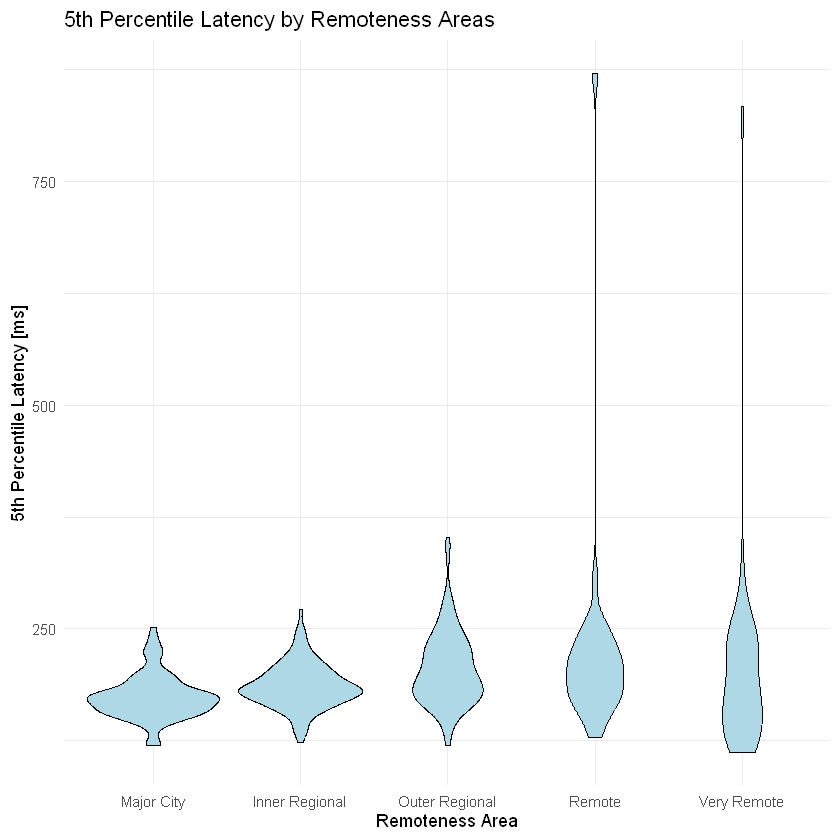

In [13]:
cleaned_data$Remoteness <- ifelse(cleaned_data$Major.City == 1, "Major City", ifelse(cleaned_data$Inner.Regional == 1, "Inner Regional", ifelse(cleaned_data$Outer.Regional == 1, "Outer Regional", ifelse(cleaned_data$Remote == 1, "Remote", "Very Remote"))))
cleaned_data$Remoteness <- factor(cleaned_data$Remoteness, levels = c("Major City", "Inner Regional", "Outer Regional", "Remote", "Very Remote"))

# Create the violin plot and assign it to variable 'p'
ggplot(cleaned_data, aes(x = Remoteness, y = X5th.Percentile)) +
  geom_violin(fill = "lightblue", color = "black") +
  labs(x = "Remoteness Area", y = "5th Percentile Latency [ms]",
       title = "5th Percentile Latency by Remoteness Areas") +
  theme_minimal()

# Create a data frame to store results of t-tests
results_table <- data.frame(Remoteness_Area_1 = character(), 
                             Remoteness_Area_2 = character(), 
                             Mean_1 = numeric(), 
                             Mean_2 = numeric(),
                             p_value = numeric(), 
                             Difference = numeric(), 
                             stringsAsFactors = FALSE)

# Perform t-tests between each pair of remoteness levels
remoteness_levels <- levels(cleaned_data$Remoteness)

for (i in 1:(length(remoteness_levels) - 1)) {
  for (j in (i + 1):length(remoteness_levels)) {
    test <- t.test(X95th.Percentile ~ Remoteness, 
                   data = cleaned_data[cleaned_data$Remoteness %in% c(remoteness_levels[i], remoteness_levels[j]), ])
    
    # Calculate means
    mean_1 <- mean(cleaned_data$X95th.Percentile[cleaned_data$Remoteness == remoteness_levels[i]], na.rm = TRUE)
    mean_2 <- mean(cleaned_data$X95th.Percentile[cleaned_data$Remoteness == remoteness_levels[j]], na.rm = TRUE)
    
    # Add results to the data frame
    results_table <- rbind(results_table, 
                            data.frame(Remoteness_Area_1 = remoteness_levels[i], 
                                       Remoteness_Area_2 = remoteness_levels[j], 
                                       Mean_1 = mean_1, Mean_2 = mean_2,
                                       p_value = format(test$p.value, nsmall = 5),
                                       Difference = mean_2 - mean_1))
  }
}

# Print the results table
print(results_table)

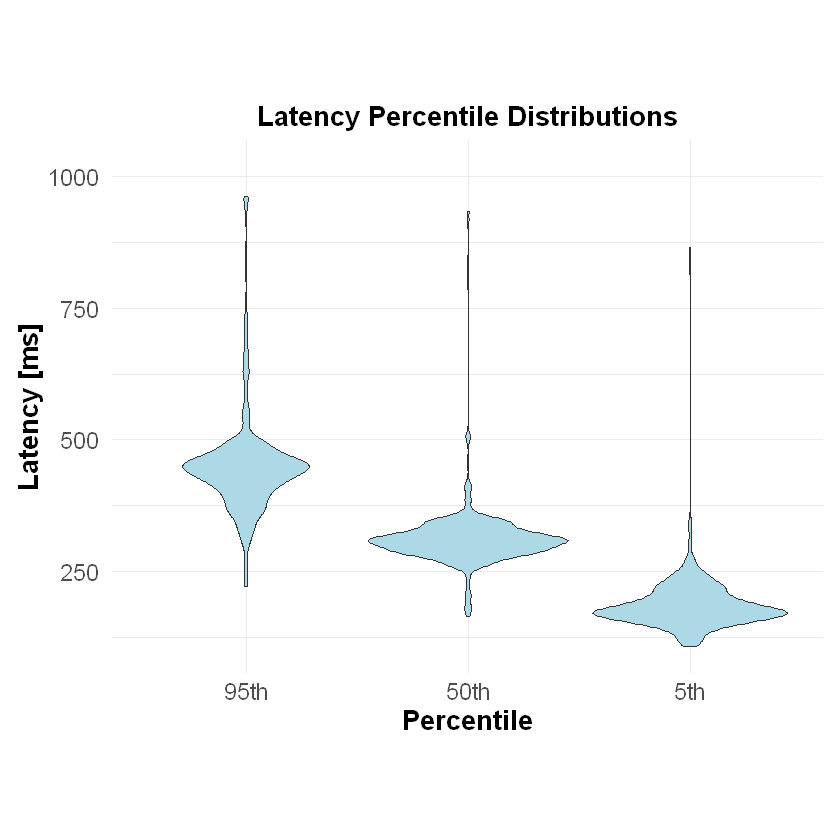

In [14]:
# Pivot the data to long format for plotting
melted_data <- pivot_longer(cleaned_data, 
                             cols = c(X5th.Percentile, X50th.Percentile, X95th.Percentile),
                             names_to = "Percentile", 
                             values_to = "Value")

# Rename and reorder the columns
melted_data$Percentile <- factor(melted_data$Percentile,
                                  levels = c("X95th.Percentile", "X50th.Percentile", "X5th.Percentile"),
                                  labels = c("95th", "50th", "5th"))

# Create the plot with swapped axes
plot <- ggplot(melted_data, aes(y = Value, x = Percentile)) +  # Swap x and y axes
  geom_violin(fill = "lightblue", width = 0.9, position = position_nudge(y = -5)) +  # Set color to light blue
  labs(title = "Latency Percentile Distributions",  # Set title
       y = "Latency [ms]",  # Renaming y-axis
       x = "Percentile") +  # Renaming x-axis
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),  # Center title
        plot.margin = margin(10, 10, 10, 10),  # Adjust margins
        axis.text.y = element_text(size = 14, margin = margin(r = 5)),  # Increase y-axis text size
        axis.text.x = element_text(size = 14),  # Increase x-axis text size
        axis.title.x = element_text(size = 16, face = "bold"),  # Increase x-axis label size and bold
        axis.title.y = element_text(size = 16, face = "bold")) +  # Increase y-axis label size and bold
  scale_y_continuous(limits = c(100, 980), expand = expansion(mult = c(0.05, 0.1))) +  # Set y-axis limits (adjust as needed)
  coord_cartesian(clip = 'off') + # Prevent clipping of the violin plots
  theme(aspect.ratio = 0.75)  # Adjust aspect ratio to make the plot shorter

# Display the plot
print(plot)


In [15]:
mean_value <- mean(cleaned_data$X50th.Percentile, na.rm = TRUE)
print(mean_value)

[1] 319.175


## Begin Fitting

In [16]:
urban_data <- cleaned_data[(cleaned_data$Major.City == 1) | (cleaned_data$Inner.Regional == 1), ]
rural_data <- cleaned_data[(cleaned_data$Major.City == 0) & (cleaned_data$Inner.Regional == 0), ]


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




0 non-numeric values turned to NA in urban data
0 non-numeric values turned to NA in rural data


Warning message:
"A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead."


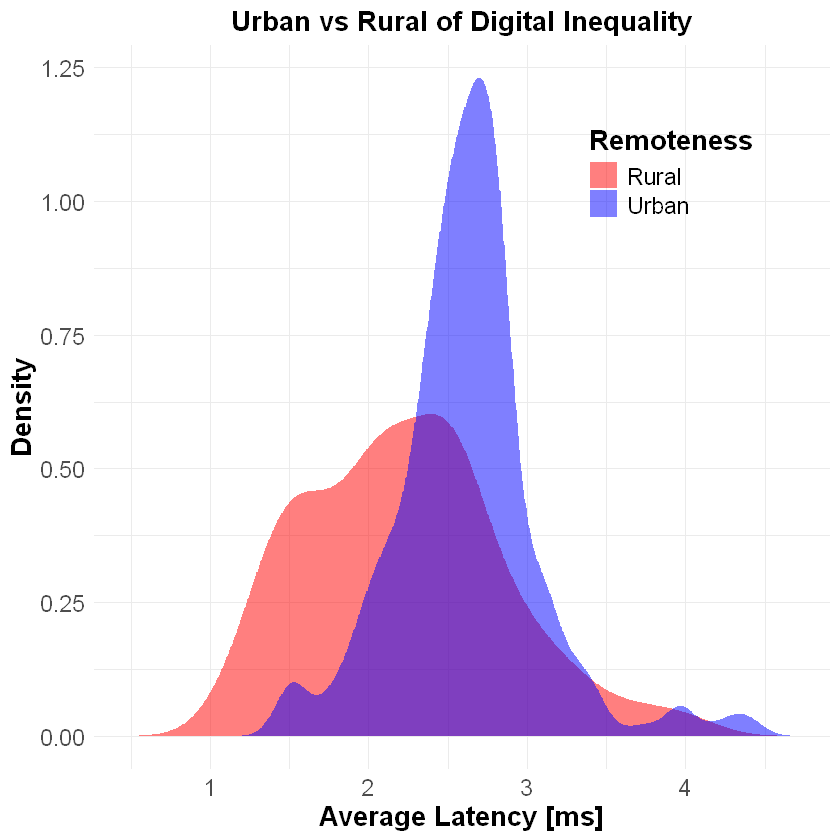

In [17]:
library(ggplot2)
library(MASS)

# Assuming urbanavgs and ruralavgs are your data vectors
# Convert the lists to numeric and drop NA values
column1 <- as.numeric(urban_data$X95th.5th.Ratio)
column2 <- as.numeric(rural_data$X95th.5th.Ratio)

# Check for NA values
cat(sum(is.na(column1)), "non-numeric values turned to NA in urban data\n")
cat(sum(is.na(column2)), "non-numeric values turned to NA in rural data\n")

# Drop NA values
column1 <- na.omit(column1)
column2 <- na.omit(column2)

# Calculate KDE for both columns
kde1 <- density(column1)
kde2 <- density(column2)

# Create a data frame for plotting
kde_data <- data.frame(
  x = c(kde1$x, kde2$x),
  density = c(kde1$y, kde2$y),
  group = rep(c("Urban", "Rural"), each = length(kde1$x))
)

# Create the plot
ggplot(kde_data, aes(x = x, y = density, fill = group)) +
  geom_area(alpha = 0.5, position = 'identity') +
  labs(
    title = "Urban vs Rural of Digital Inequality",
    x = "Average Latency [ms]",
    y = "Density",
    fill = "Remoteness"
  ) +
  scale_fill_manual(values = c("Urban" = "blue", "Rural" = "red")) +
  scale_x_continuous(limits = c(NA, NA)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14),
    legend.title = element_text(size = 16, face = "bold"),
    legend.text = element_text(size = 14),
    legend.position = c(0.9, 0.9),  # Position the legend in the upper right corner
    legend.justification = c("right", "top"))


In [18]:
cor_matrix <- cor(cleaned_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")
#cor_matrix

#write.csv(cor_matrix, file = "correlation_matrix.csv", row.names = FALSE)

urban_cor_matrix <- cor(urban_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(urban_cor_matrix, file = "urban_correlation_matrix.csv", row.names = FALSE)

# rural correlation matrix
rural_cor_matrix <- cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(rural_cor_matrix, file = "rural_correlation_matrix.csv", row.names = FALSE)


Warning message in cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile", :
"the standard deviation is zero"


In [19]:
print(cor_matrix)

                          IRSD.Decile IRSAD.Decile   IER.Decile  IEO.Decile
IRSD.Decile                1.00000000   0.94941488  0.794597164  0.83690150
IRSAD.Decile               0.94941488   1.00000000  0.715865333  0.92254124
IER.Decile                 0.79459716   0.71586533  1.000000000  0.57188633
IEO.Decile                 0.83690150   0.92254124  0.571886332  1.00000000
Median.Income              0.53401994   0.55627944  0.343053967  0.41770344
Lowest.Quartile.Income..  -0.45086656  -0.49231057 -0.312807949 -0.34074806
Highest.Quartile.Income..  0.62628459   0.64417876  0.416018831  0.50779029
Gini.Coefficient           0.20137928   0.16456813  0.151254093  0.21785822
Area..Km.2.               -0.24517589  -0.22689673 -0.281722917 -0.22720125
major_city_distance       -0.33523751  -0.33267519 -0.382343259 -0.38394748
closest_capital_distance  -0.32683514  -0.34114638 -0.390802443 -0.38270195
own_capital_distance      -0.35065646  -0.34941644 -0.405063968 -0.36143071
Population  

In [20]:
# Create scaled (normalised) versions of the combined data
cleaned_scaled <- as.data.frame(scale(cleaned_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

# Remove data points greater than 3 or less than -3
cleaned_scaled$Major.City <- cleaned_data$Major.City
cleaned_scaled$Inner.Regional <- cleaned_data$Inner.Regional
cleaned_scaled$Outer.Regional <- cleaned_data$Outer.Regional
cleaned_scaled$Remote <- cleaned_data$Remote
cleaned_scaled$Very.Remote <- cleaned_data$Very.Remote
rows_to_keep <- apply(cleaned_scaled, 1, function(x) all(x <= 3 & x >= -3))
cleaned_scaled <- cleaned_scaled[rows_to_keep, ]

# Add the unscaled percentile columns back in (filtering by the same rows)
cleaned_scaled$X5th.Percentile <- cleaned_data$X5th.Percentile[rows_to_keep]
cleaned_scaled$X50th.Percentile <- cleaned_data$X50th.Percentile[rows_to_keep]
cleaned_scaled$X95th.Percentile <- cleaned_data$X95th.Percentile[rows_to_keep]
cleaned_scaled$X95th.5th.Ratio <- cleaned_data$X95th.5th.Ratio[rows_to_keep]

# Repeat for urban and rural data
urban_scaled <- as.data.frame(scale(urban_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing', 'Seat.Change',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

rows_to_keep_urban <- apply(urban_scaled, 1, function(x) all(x <= 3 & x >= -3))
urban_scaled <- urban_scaled[rows_to_keep_urban, ]
urban_scaled$X5th.Percentile <- urban_data$X5th.Percentile[rows_to_keep_urban]
urban_scaled$X50th.Percentile <- urban_data$X50th.Percentile[rows_to_keep_urban]
urban_scaled$X95th.Percentile <- urban_data$X95th.Percentile[rows_to_keep_urban]
urban_scaled$X95th.5th.Ratio <- urban_data$X95th.5th.Ratio[rows_to_keep_urban]

rural_scaled <- as.data.frame(scale(rural_data[, c('IRSAD.Decile', 'Median.Income', 'Gini.Coefficient', 'Area..Km.2.', 
                                                       'closest_capital_distance', 'Population', 'Population.Density', 
                                                       'Population.Change..','Indigenous.Population..','Swing',
                                                       'is.Safe', 'is.Marginal', 'Remained.Marginal')]))

rows_to_keep_rural <- apply(rural_scaled, 1, function(x) all(x <= 3 & x >= -3))
rural_scaled <- rural_scaled[rows_to_keep_rural, ]
rural_scaled$X5th.Percentile <- rural_data$X5th.Percentile[rows_to_keep_rural]
rural_scaled$X50th.Percentile <- rural_data$X50th.Percentile[rows_to_keep_rural]
rural_scaled$X95th.Percentile <- rural_data$X95th.Percentile[rows_to_keep_rural]
rural_scaled$X95th.5th.Ratio <- rural_data$X95th.5th.Ratio[rows_to_keep_rural]

print(sum(complete.cases(cleaned_scaled)))
print(sum(complete.cases(urban_scaled)))
print(sum(complete.cases(rural_scaled)))

[1] 351
[1] 199
[1] 152


In [21]:
summary(cleaned_scaled$Indigenous.Population..)
summary(urban_scaled$Indigenous.Population..)
summary(rural_scaled$Indigenous.Population..)
summary(rural_scaled$X5th.Percentile)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.56393 -0.46014 -0.31177 -0.16648 -0.06276  2.72937 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.05895 -0.78953 -0.35316 -0.05094  0.45317  2.67487 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.7183 -0.5569 -0.3851 -0.2076 -0.1047  2.9345 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  116.2   172.8   193.7   209.4   229.1   870.4 

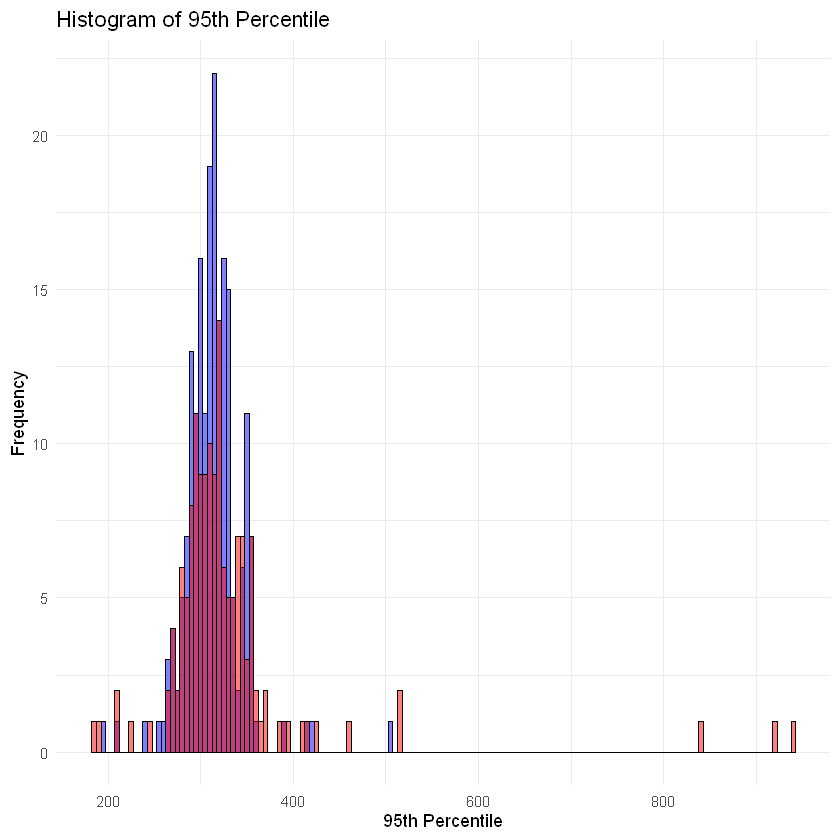

In [22]:
# First histogram for urban data
p <- ggplot(urban_scaled, aes(x = X50th.Percentile)) +
  geom_histogram(binwidth = 5, fill = "blue", color = "black", alpha = 0.5) +
  labs(title = "Histogram of 95th Percentile", x = "95th Percentile", y = "Frequency") +
  theme_minimal()

# Add the rural histogram
p + geom_histogram(data = rural_scaled, aes(x = X50th.Percentile), 
                   binwidth = 5, fill = "red", color = "black", alpha = 0.5)

In [23]:
# Keep only rows where X5th.Percentile is less than 500
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X5th.Percentile < 300, ]
urban_scaled <- urban_scaled[urban_scaled$X5th.Percentile < 300, ]
rural_scaled <- rural_scaled[rural_scaled$X5th.Percentile < 300, ]

# Keep only rows where X50.Percentile is less than 500
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X50th.Percentile < 500, ]
urban_scaled <- urban_scaled[urban_scaled$X50th.Percentile < 500, ]
rural_scaled <- rural_scaled[rural_scaled$X50th.Percentile < 500, ]

# Keep only rows where X95.Percentile is less than 750
cleaned_scaled <- cleaned_scaled[cleaned_scaled$X95th.Percentile < 750, ]
urban_scaled <- urban_scaled[urban_scaled$X95th.Percentile < 750, ]
rural_scaled <- rural_scaled[rural_scaled$X95th.Percentile < 750, ]


In [24]:
# Assuming you have a data frame called 'data' that contains your columns
result <- t.test(urban_scaled$X95th.Percentile, 
                 rural_scaled$X95th.Percentile,
                 var.equal = FALSE) 

print(result)


	Welch Two Sample t-test

data:  urban_scaled$X95th.Percentile and rural_scaled$X95th.Percentile
t = 4.6155, df = 229.07, p-value = 6.532e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 20.31771 50.58722
sample estimates:
mean of x mean of y 
 460.8774  425.4250 



In [25]:
fit <- lm(cleaned_scaled$X50th.Percentile ~ IRSAD.Decile +
            Gini.Coefficient + Area..Km.2. +  
            closest_capital_distance + Population + Population.Density + 
            + Population.Change.. + Indigenous.Population.. +
            Swing + is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_scaled)

## AIC

In [26]:
# Fit the model with stepwise AIC selection
fit_aic <- step(fit)
summary(fit_aic)

Start:  AIC=2343.27
cleaned_scaled$X50th.Percentile ~ IRSAD.Decile + Gini.Coefficient + 
    Area..Km.2. + closest_capital_distance + Population + Population.Density + 
    +Population.Change.. + Indigenous.Population.. + Swing + 
    is.Safe + is.Marginal + Remained.Marginal

                           Df Sum of Sq    RSS    AIC
- Area..Km.2.               1       0.2 304796 2341.3
- Population.Change..       1      12.4 304808 2341.3
- Indigenous.Population..   1      62.4 304859 2341.3
- IRSAD.Decile              1     157.5 304954 2341.4
- Remained.Marginal         1     408.2 305204 2341.7
- is.Marginal               1     977.6 305774 2342.4
<none>                                  304796 2343.3
- Gini.Coefficient          1    2077.9 306874 2343.6
- is.Safe                   1    3863.5 308660 2345.6
- Population                1    4716.4 309512 2346.5
- closest_capital_distance  1    6560.6 311357 2348.5
- Population.Density        1    7406.9 312203 2349.5
- Swing             


Call:
lm(formula = cleaned_scaled$X50th.Percentile ~ Gini.Coefficient + 
    closest_capital_distance + Population + Population.Density + 
    Swing + is.Safe + is.Marginal, data = cleaned_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-131.713  -14.682   -1.066   16.974  122.630 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               310.434      1.752 177.199  < 2e-16 ***
Gini.Coefficient           -3.499      2.184  -1.602 0.110017    
closest_capital_distance   -9.985      2.728  -3.661 0.000292 ***
Population                 -6.483      2.872  -2.257 0.024639 *  
Population.Density         -7.620      2.544  -2.995 0.002947 ** 
Swing                      -5.411      1.760  -3.075 0.002282 ** 
is.Safe                     4.333      2.149   2.016 0.044626 *  
is.Marginal                 3.333      2.142   1.556 0.120688    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard err

## BIC

In [27]:
fit_bic <- step(fit, direction = "both", k = log(nrow(cleaned_data)))
summary(fit_bic)

Start:  AIC=2395.19
cleaned_scaled$X50th.Percentile ~ IRSAD.Decile + Gini.Coefficient + 
    Area..Km.2. + closest_capital_distance + Population + Population.Density + 
    +Population.Change.. + Indigenous.Population.. + Swing + 
    is.Safe + is.Marginal + Remained.Marginal

                           Df Sum of Sq    RSS    AIC
- Area..Km.2.               1       0.2 304796 2389.2
- Population.Change..       1      12.4 304808 2389.2
- Indigenous.Population..   1      62.4 304859 2389.3
- IRSAD.Decile              1     157.5 304954 2389.4
- Remained.Marginal         1     408.2 305204 2389.7
- is.Marginal               1     977.6 305774 2390.3
- Gini.Coefficient          1    2077.9 306874 2391.5
- is.Safe                   1    3863.5 308660 2393.5
- Population                1    4716.4 309512 2394.4
<none>                                  304796 2395.2
- closest_capital_distance  1    6560.6 311357 2396.5
- Population.Density        1    7406.9 312203 2397.4
- Swing             


Call:
lm(formula = cleaned_scaled$X50th.Percentile ~ closest_capital_distance + 
    Population.Density + Swing, data = cleaned_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-126.359  -15.776    0.225   17.796  115.415 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               310.880      1.751 177.586  < 2e-16 ***
closest_capital_distance   -8.565      2.679  -3.197  0.00152 ** 
Population.Density         -9.631      2.379  -4.049  6.4e-05 ***
Swing                      -4.915      1.732  -2.837  0.00482 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 30.56 on 337 degrees of freedom
Multiple R-squared:  0.06413,	Adjusted R-squared:  0.0558 
F-statistic: 7.697 on 3 and 337 DF,  p-value: 5.467e-05


## Ridge Regression

[1] 23.92678



Call:
glm(formula = formula, data = urban_scaled)

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              180.2364     1.8004 100.109   <2e-16 ***
IRSAD.Decile              -2.4959     3.0490  -0.819   0.4141    
Median.Income             -1.6370     2.9184  -0.561   0.5755    
Gini.Coefficient          -0.1105     2.7745  -0.040   0.9683    
Area..Km.2.                4.7974     2.9550   1.623   0.1062    
closest_capital_distance   1.0596     3.0474   0.348   0.7285    
Population                -4.1545     3.0096  -1.380   0.1691    
Population.Density        -3.5383     3.1436  -1.126   0.2618    
Population.Change..       -0.9782     2.0464  -0.478   0.6332    
Indigenous.Population..   -2.1812     2.8736  -0.759   0.4488    
Swing                     -0.5635     2.0991  -0.268   0.7886    
is.Safe                    3.5435     2.2678   1.562   0.1199    
is.Marginal                4.7398     2.8079   1.688   0.0931 .  
Remained.M

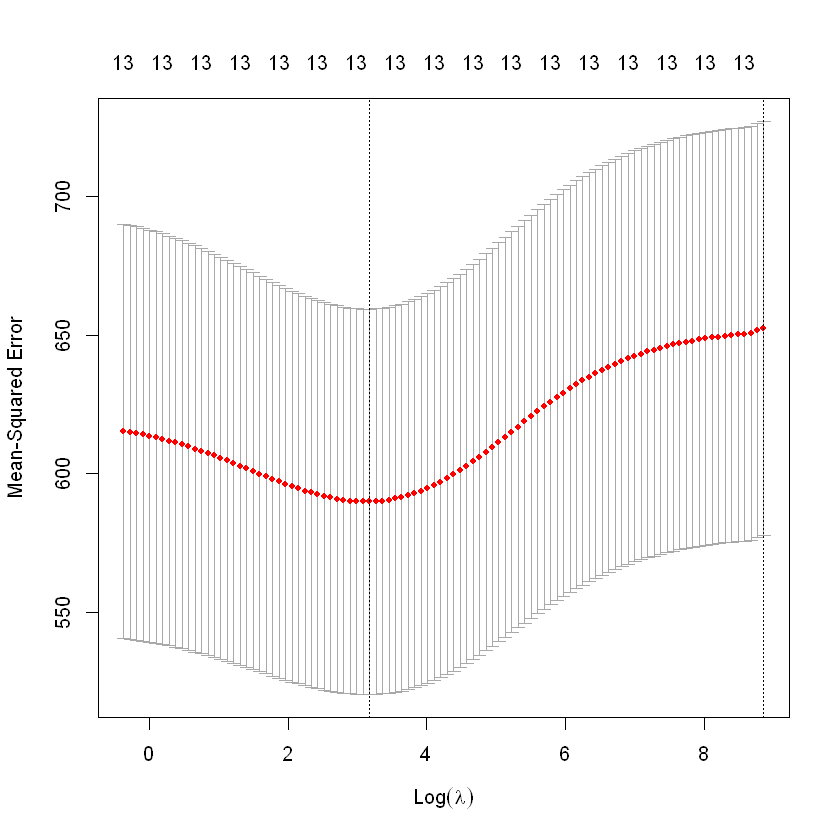

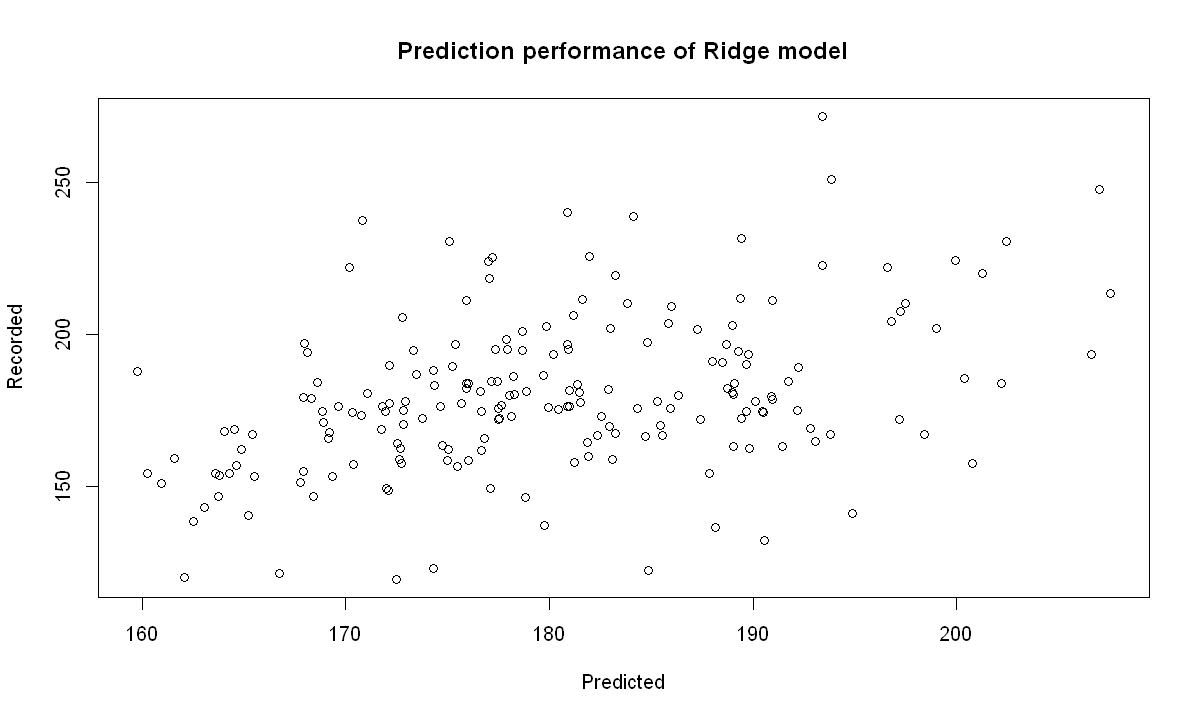

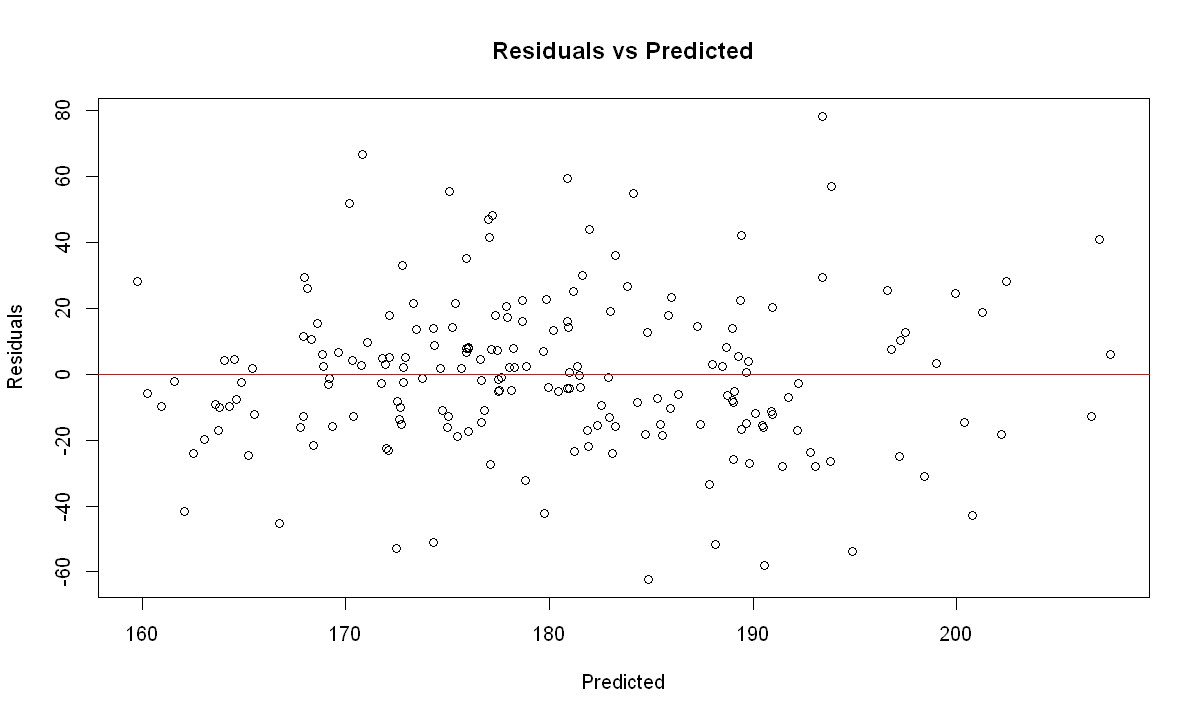

In [28]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(urban_scaled$X5th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = urban_scaled)

y <- urban_scaled$X5th.Percentile

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = 0)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = 0, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("X5th.Percentile ~", paste(selected_vars, collapse = " + ")))
ridge_model <- glm(formula, data = urban_scaled)
summary(ridge_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(ridge_model, urban_scaled), urban_scaled$X5th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(ridge_model$fitted.values, resid(ridge_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

`geom_smooth()` using formula = 'y ~ x'


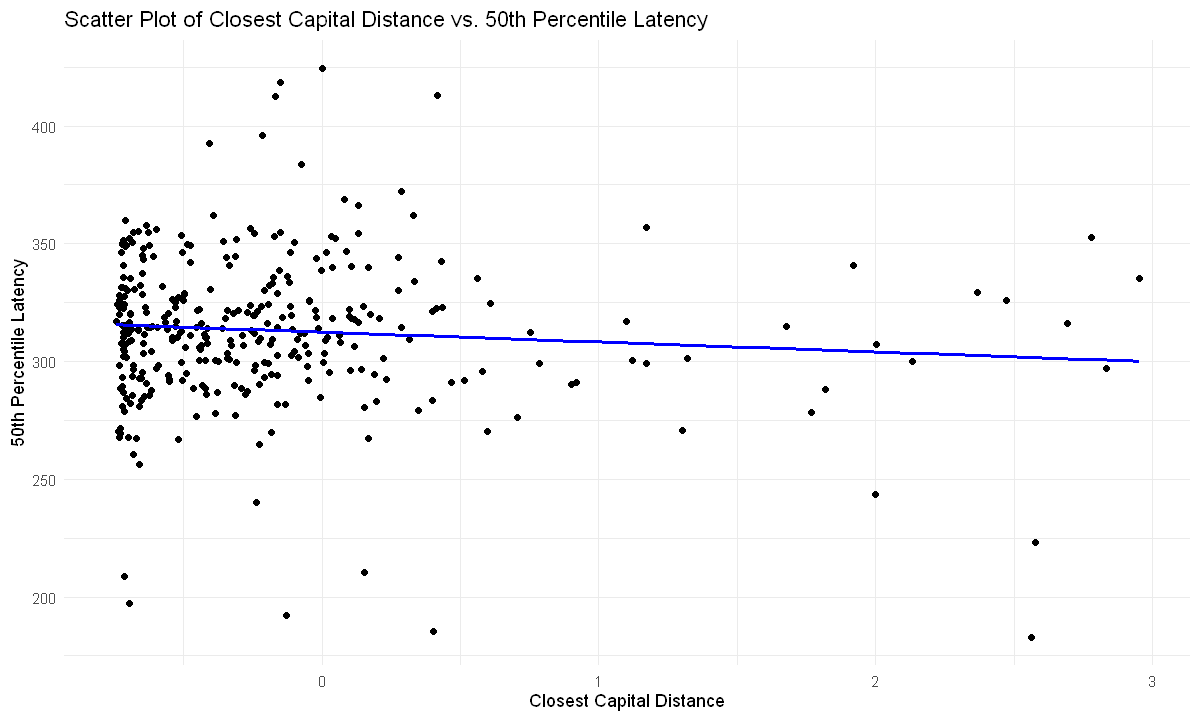

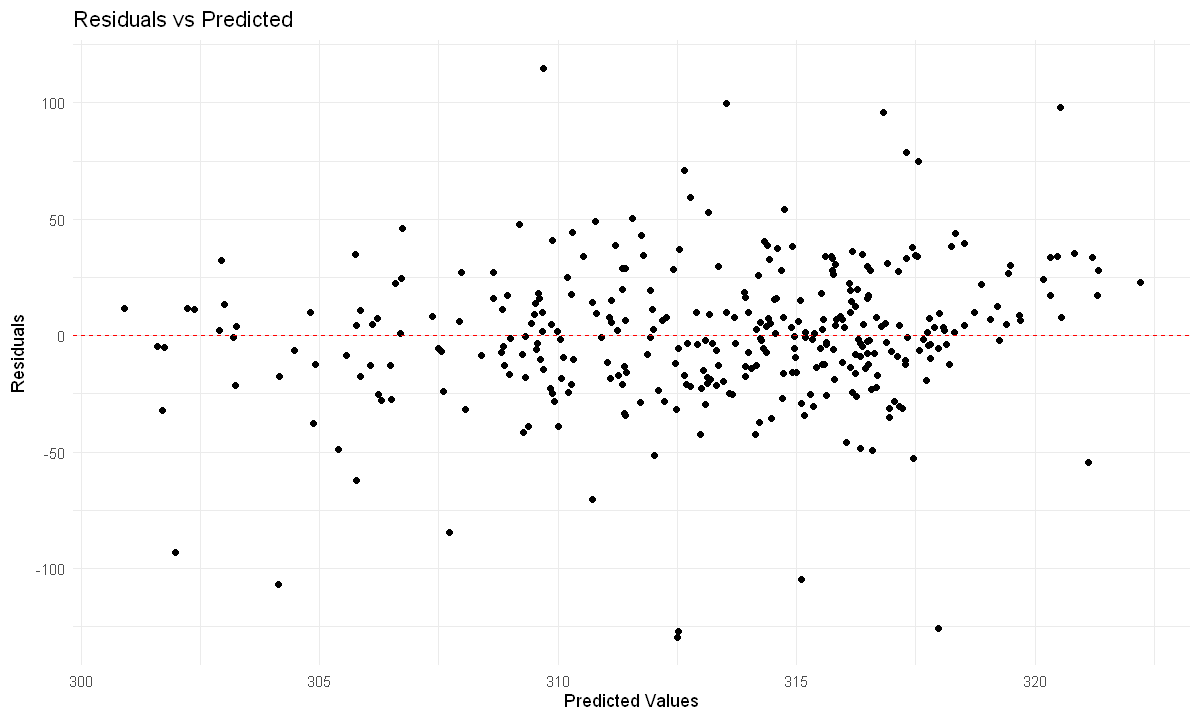

In [29]:
# Define predictors (excluding unwanted variables)
predictors <- c("IRSAD.Decile", "Median.Income", "Gini.Coefficient", "Area..Km.2.", 
                "closest_capital_distance", "Population", "Population.Density", 
                "Population.Change..", "Indigenous.Population..", "Swing", 
                "is.Safe", "is.Marginal", "Remained.Marginal")

# Prepare the model matrix and response variable
x <- model.matrix(X50th.Percentile ~ ., data = cleaned_scaled[, c(predictors, "X50th.Percentile")])
y <- cleaned_scaled$X50th.Percentile

# Fit the ridge regression model (alpha = 0)
ridge_model <- cv.glmnet(x, y, alpha = 0)

# Scatter Plot of Closest Capital Distance vs. 50th Percentile Latency
ggplot(cleaned_scaled, aes(x = closest_capital_distance, y = X50th.Percentile)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(title = "Scatter Plot of Closest Capital Distance vs. 50th Percentile Latency",
       x = "Closest Capital Distance",
       y = "50th Percentile Latency") +
  theme_minimal()

# Obtain predictions from the ridge model
predicted_values <- predict(ridge_model, newx = x, s = "lambda.min")

# Calculate residuals
residuals <- cleaned_scaled$X50th.Percentile - as.vector(predicted_values)

# Plot Residuals vs Predicted
ggplot(data.frame(Predicted = as.vector(predicted_values), Residuals = residuals), 
       aes(x = Predicted, y = Residuals)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "Residuals vs Predicted",
       x = "Predicted Values",
       y = "Residuals") +
  theme_minimal()


## Lasso Regression

[1] 1.104631


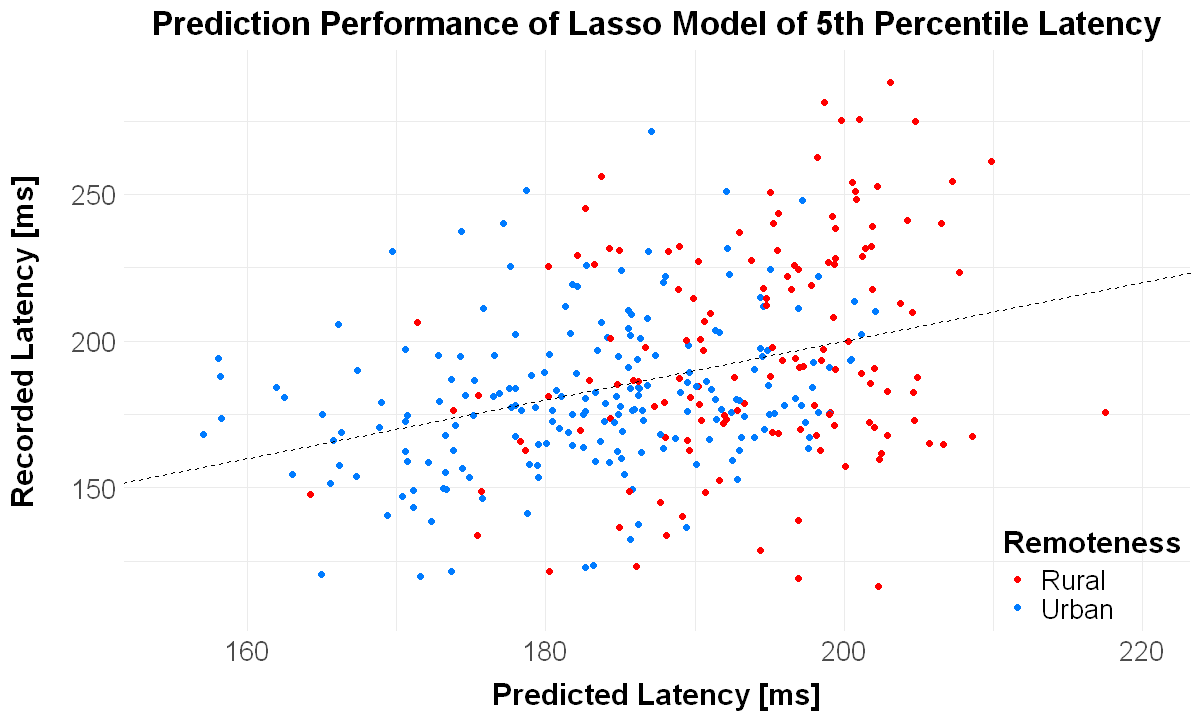

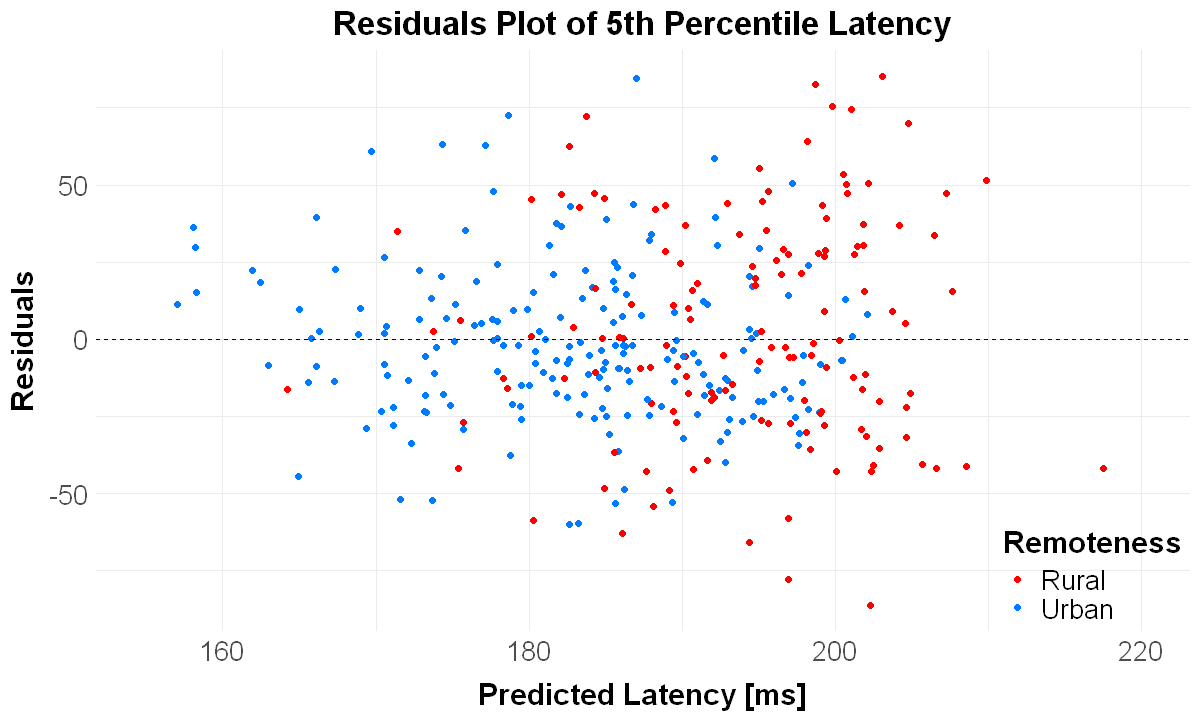

In [51]:
# Classify the data into urban and rural
cleaned_scaled$Remoteness <- ifelse(cleaned_scaled$Major.City == 1 | cleaned_scaled$Inner.Regional == 1, "Urban", "Rural")

cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_scaled$X5th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_scaled)

y <- cleaned_scaled$X5th.Percentile

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = 1)

# Plot the cross-validation curve
par(bg= "white")
#plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = 1, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]
if (length(selected_vars) == 0) {print('No variables selected')}

# Create a formula for the selected variables
formula <- as.formula(paste("X5th.Percentile ~", paste(selected_vars, collapse = " + ")))
lasso_model <- glm(formula, data = cleaned_scaled)
#summary(lasso_model)

# Set up the plot for prediction performance
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust size to be smaller
ggplot(cleaned_scaled, aes(x = predict(lasso_model, cleaned_scaled), y = X5th.Percentile, color = Remoteness)) +
  geom_point() +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black") +  # Add the y = x line
  labs(title = "Prediction Performance of Lasso Model of 5th Percentile Latency", 
       y = "Recorded Latency [ms]", x = "Predicted Latency [ms]") +
  scale_color_manual(values = c("Urban" = "#007BFF", "Rural" = "red")) +
  scale_x_continuous(limits = c(155, 220)) +
  scale_y_continuous(limits = c(110, 290)) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),  # Center and bold title
    axis.title.x = element_text(size = 18, face = "bold", margin = margin(t = 10)),  # Bold x-axis title
    axis.title.y = element_text(size = 18, face = "bold", margin = margin(r = 20)),  # Bold y-axis title
    legend.title = element_text(size = 18, face = "bold"),  # Bold legend title
    legend.text = element_text(size = 16),  # Larger legend text
    axis.text = element_text(size = 16),  # Larger axis text
    legend.position = c(1.0, 0.0),  # Position the legend in the upper right corner
    legend.justification = c("right", "bottom")  # Justify the legend to the right and top
  )

# Residuals vs Predicted plot
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust size to be smaller
ggplot(data.frame(Predicted = predict(lasso_model, cleaned_scaled), Residuals = resid(lasso_model), Remoteness = cleaned_scaled$Remoteness), 
       aes(x = Predicted, y = Residuals, color = Remoteness)) +
  geom_point() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Residuals Plot of 5th Percentile Latency", 
       x = "Predicted Latency [ms]", 
       y = "Residuals") +
  scale_x_continuous(limits = c(155, 220)) +
  scale_color_manual(values = c("Urban" = "#007BFF", "Rural" = "red")) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),  # Center and bold title
    axis.title.x = element_text(size = 18, face = "bold", margin = margin(t = 10)),  # Bold x-axis title
    axis.title.y = element_text(size = 18, face = "bold"),  # Bold y-axis title
    legend.title = element_text(size = 18, face = "bold"),  # Bold legend title
    legend.text = element_text(size = 16),  # Larger legend text
    axis.text = element_text(size = 16),  # Larger axis text
    legend.position = c(1.0, 0.0),  # Position the legend in the upper right corner
    legend.justification = c("right", "bottom")  # Justify the legend to the right and top
  )


In [97]:
summary(cleaned_scaled$X5th.Percentile)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  116.2   167.8   181.5   187.6   206.2   288.1 

## Elastic Net Regression

Best alpha: 0.4 
[1] 0.05186234


           Length Class  Mode     
lambda     100    -none- numeric  
cvm        100    -none- numeric  
cvsd       100    -none- numeric  
cvup       100    -none- numeric  
cvlo       100    -none- numeric  
nzero      100    -none- numeric  
call         4    -none- call     
name         1    -none- character
glmnet.fit  12    elnet  list     
lambda.min   1    -none- numeric  
lambda.1se   1    -none- numeric  
index        2    -none- numeric  

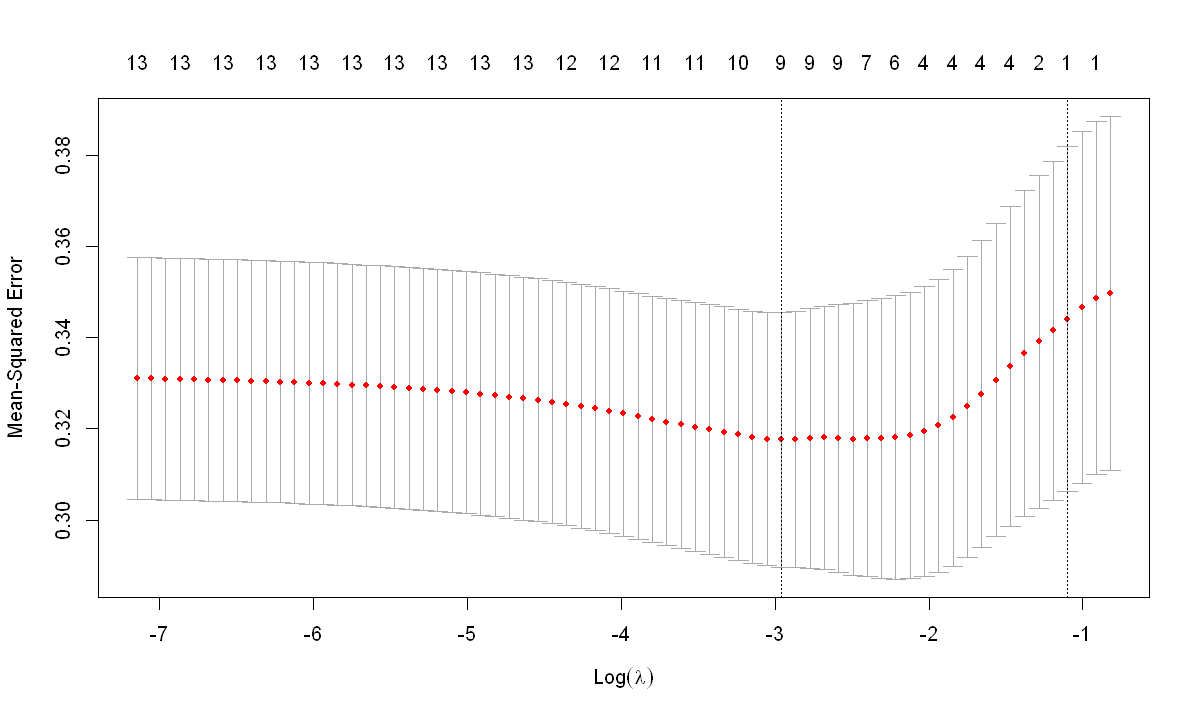

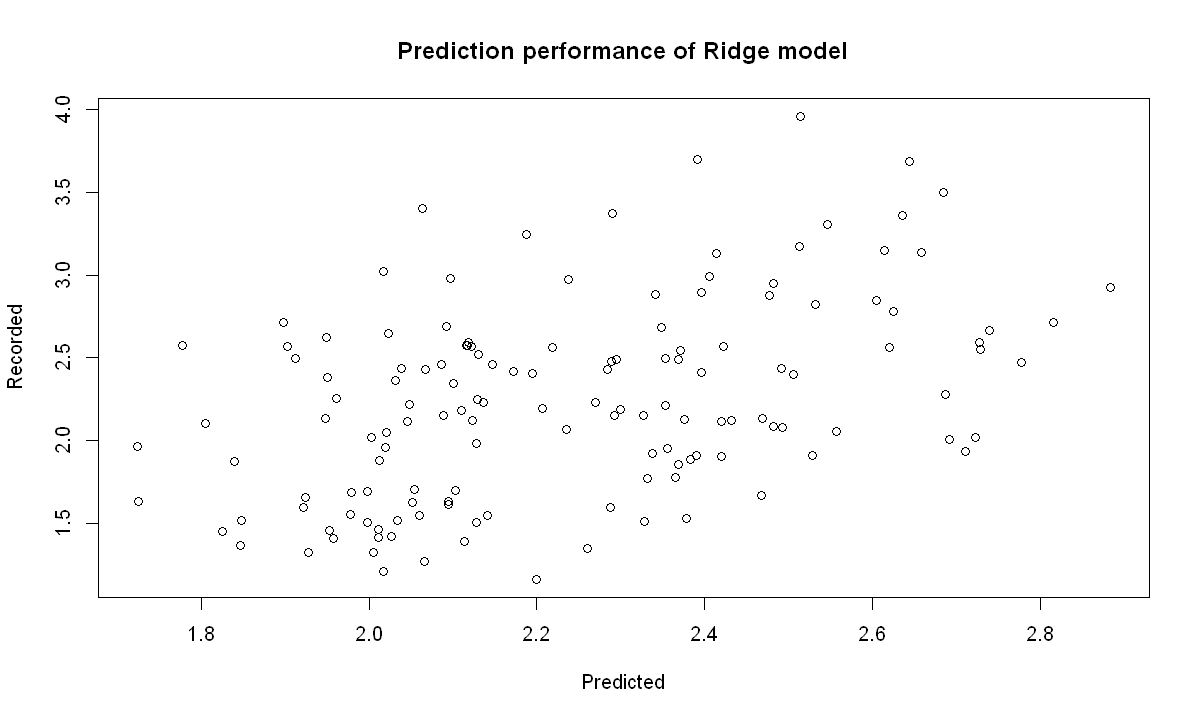

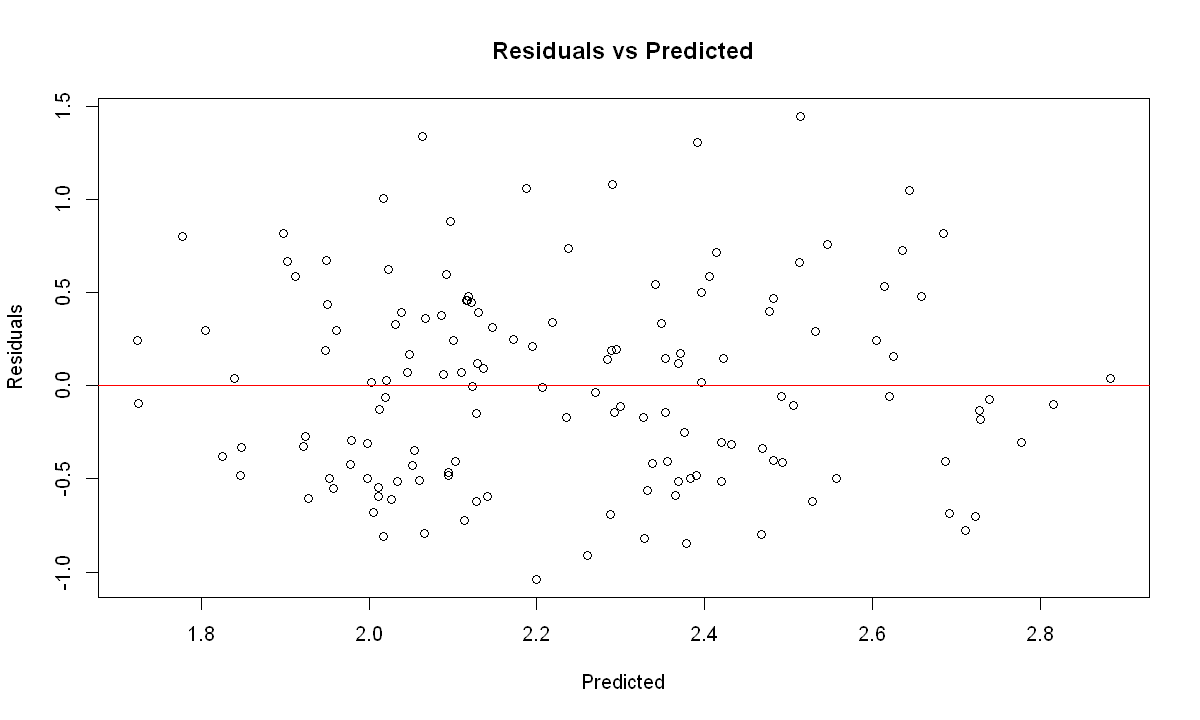

In [20]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(rural_scaled$X95th.5th.Ratio ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = rural_scaled)

y <- rural_scaled$X95th.5th.Ratio

# Find the best alpha
best_alpha <- cv_alpha(x, y)
cat("Best alpha:", best_alpha, "\n")

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = best_alpha)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = best_alpha, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]
if (length(selected_vars) == 0) {print('No variables selected')}

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.5th.Ratio ~", paste(selected_vars, collapse = " + ")))
elastic_model <- glm(formula, data = rural_scaled)
summary(ridge_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(elastic_model, rural_scaled), rural_scaled$X95th.5th.Ratio, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(elastic_model$fitted.values, resid(elastic_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## Visualise Individual Variable

[1] "Pearson Correlation Coefficient: -0.0744549803052362"

	Spearman's rank correlation rho

data:  independent_var and target_var
S = 517610, p-value = 0.4608
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.06210398 



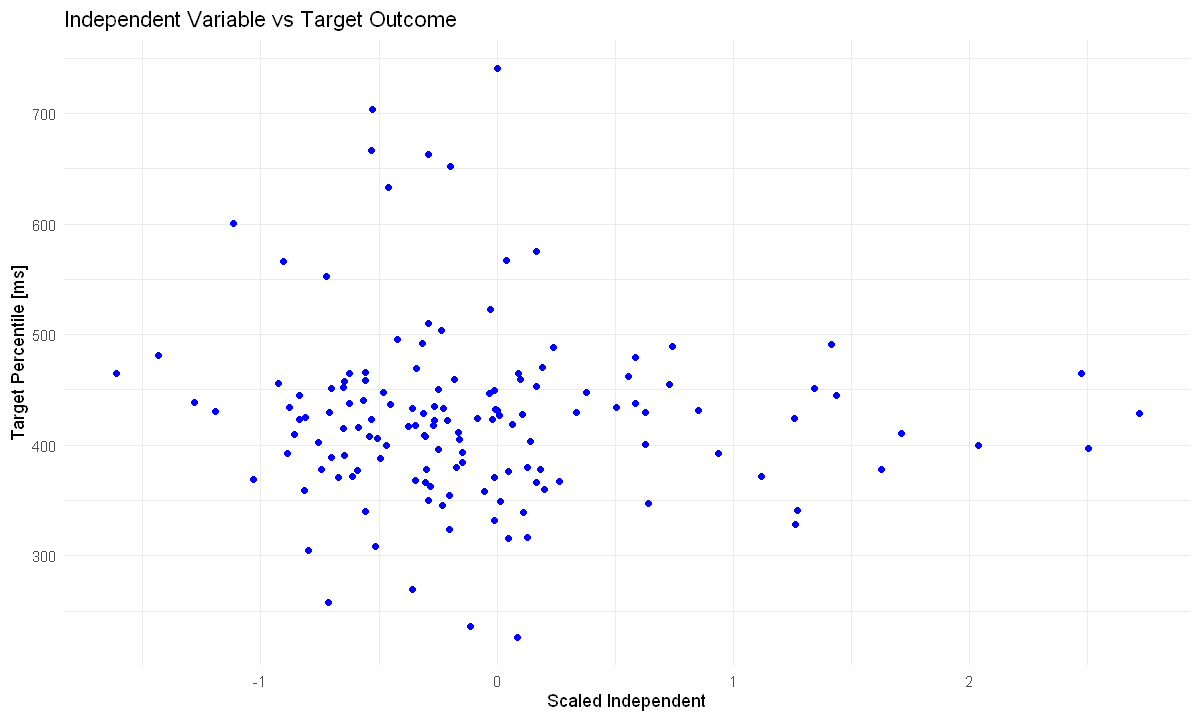

In [26]:
data = rural_scaled
x = data$Median.Income
y = data$X95th.Percentile
independent_var <- x
target_var <- y

# Correlation Analysis
correlation_result <- cor(independent_var, target_var)
print(paste("Pearson Correlation Coefficient:", correlation_result))

# Non-Parametric Test: Spearman's Rank Correlation
spearman_result <- cor.test(independent_var, target_var, method = "spearman")
print(spearman_result)

ggplot(data, aes(x = x, y = y)) +
  geom_point(color = "blue") +
  labs(title = "Independent Variable vs Target Outcome", x = "Scaled Independent", y = "Target Percentile [ms]") +
  theme_minimal()


### perform and plot the predictions

[1] 22912.46

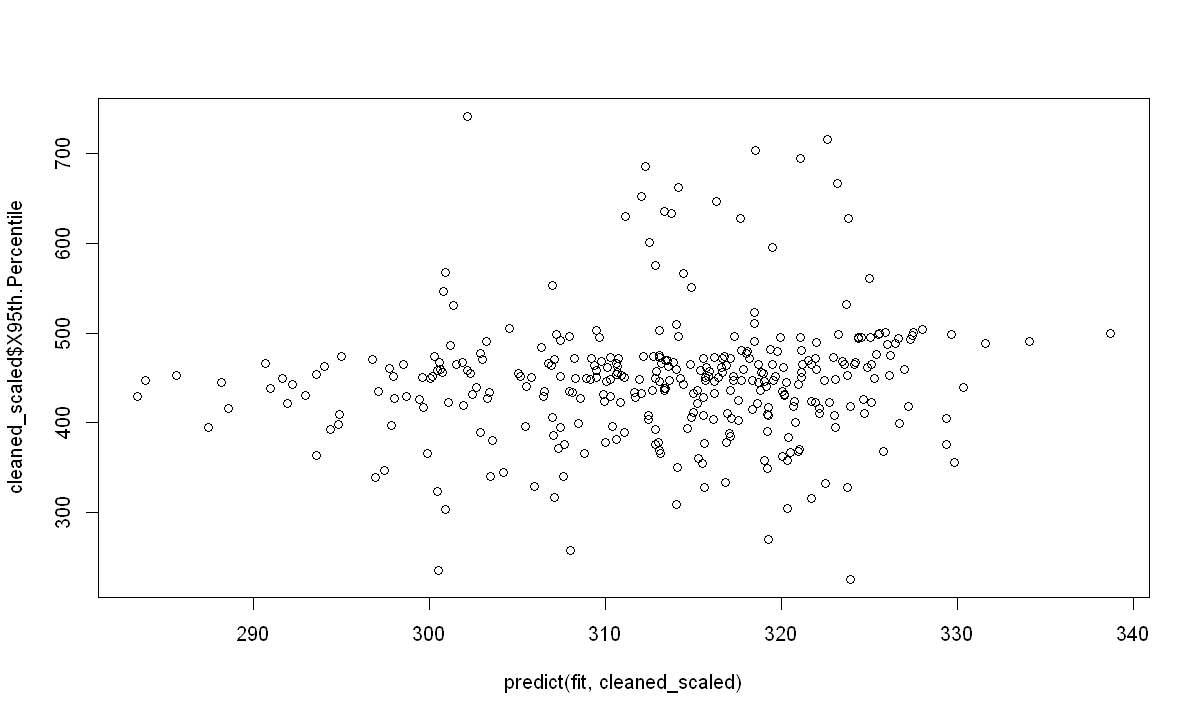

In [22]:
par(bg = "white")
predictions <- predict(fit, cleaned_scaled)
plot(predict(fit, cleaned_scaled), cleaned_scaled$X95th.Percentile)
#calculate mean squared error
mean((predictions - cleaned_scaled$X95th.Percentile)^2)

## Unscaling the Coefficients

In [23]:
calculate_impacts <- function(data, variables, coefficients) {
  # Initialize a vector to store the impacts
  impacts <- numeric(length(variables))
  
  # Loop through each variable and calculate the impact
  for (i in seq_along(variables)) {
    column <- data[[variables[i]]]
    coef <- coefficients[i]
    impacts[i] <- coef * (max(column, na.rm = TRUE) - min(column, na.rm = TRUE))
  }
  
  # Create a data frame to return results
  results <- data.frame(Variable = variables, Impact = impacts)
  return(results)
}

# Example usage
variables <- c("Area..Km.2.", "Population", "Population.Density", "is.Safe")  # Replace with your variable names
coefficients <- c(-12.743659, -6.044372, -6.708125, 4.232469)  # Replace with your corresponding coefficients

impact_results <- calculate_impacts(cleaned_scaled, variables, coefficients)
print(impact_results)


            Variable     Impact
1        Area..Km.2. -29.807914
2         Population -20.998319
3 Population.Density -22.488057
4            is.Safe   8.523593


In [24]:
cleaned_unscaled <- cleaned_data[rows_to_keep, ]
urban_unscaled <- urban_data[rows_to_keep_urban, ]
rural_unscaled <- rural_data[rows_to_keep_rural, ]

# Keep only rows where X5th.Percentile is less than 500
cleaned_unscaled <- cleaned_scaled[cleaned_scaled$X5th.Percentile < 300, ]
urban_unscaled <- urban_scaled[urban_scaled$X5th.Percentile < 300, ]
rural_unscaled <- rural_scaled[rural_scaled$X5th.Percentile < 300, ]

# Keep only rows where X50.Percentile is less than 500
cleaned_unscaled <- cleaned_scaled[cleaned_scaled$X50th.Percentile < 500, ]
urban_unscaled <- urban_scaled[urban_scaled$X50th.Percentile < 500, ]
rural_unscaled <- rural_scaled[rural_scaled$X50th.Percentile < 500, ]

# Keep only rows where X95.Percentile is less than 750
cleaned_unscaled <- cleaned_scaled[cleaned_scaled$X95th.Percentile < 750, ]
urban_unscaled <- urban_scaled[urban_scaled$X95th.Percentile < 750, ]
rural_unscaled <- rural_scaled[rural_scaled$X95th.Percentile < 750, ]

calculate_standardized_impacts <- function(data, std_data, variables, coefficients) {
  # Initialize a vector to store the impacts
  impacts <- numeric(length(variables))
  
  # Loop through each variable and calculate the impact
  for (i in seq_along(variables)) {
    column <- data[[variables[i]]]
    std_dev <- sd(std_data[[variables[i]]], na.rm = TRUE)  # Standard deviation from the new dataframe
    coef <- coefficients[i]
    
    # Calculate the standardized impact
    impacts[i] <- coef / std_dev
  }
  
  # Create a data frame to return results
  results <- data.frame(Variable = variables, Standardized_Impact = impacts)
  return(results)
}

# Example usage
variables <- c("Population", "Population.Density", "Swing", "is.Safe")  # Replace with your variable names
coefficients <- c(-7.129, -7.249, -4.716, 4.4721)  # Replace with your corresponding coefficients

# Assume std_data is your new dataframe containing the same variables
std_data <- cleaned_unscaled  # Replace this with your actual standard deviation dataframe

standardized_impact_results <- calculate_standardized_impacts(cleaned_scaled, std_data, variables, coefficients)
print(standardized_impact_results)


            Variable Standardized_Impact
1         Population          -10.448669
2 Population.Density           -9.294007
3              Swing           -4.792287
4            is.Safe            4.470493


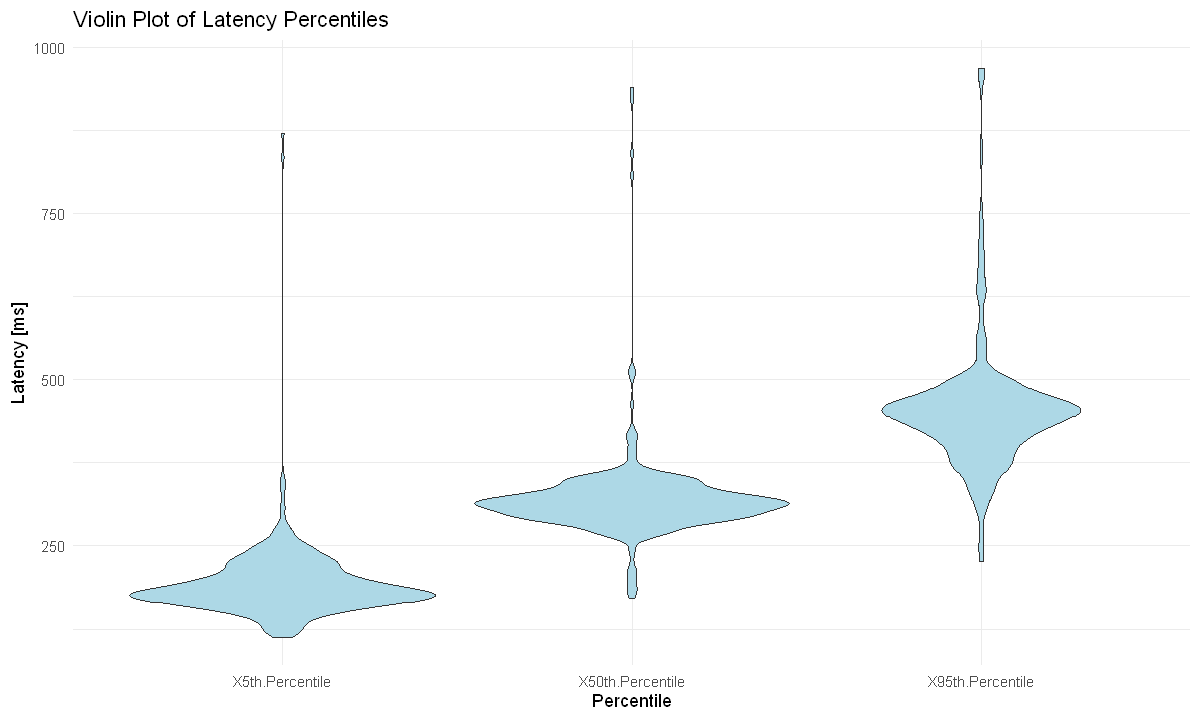

In [25]:
# Reshape the data to long format
long_data <- melt(cleaned_data, measure.vars = c("X5th.Percentile", "X50th.Percentile", "X95th.Percentile"),
                  variable.name = "Percentile", value.name = "Latency")

# Create the violin plot
ggplot(long_data, aes(x = Percentile, y = Latency)) +
  geom_violin(fill = "lightblue") +
  labs(title = "Violin Plot of Latency Percentiles",
       x = "Percentile",
       y = "Latency [ms]") +
  theme_minimal()